# This is a demo-notebook that will load some of the ERA5 data on the UCAR Casper analysis cluster. 

Marysa Lague
Aug 24, 2023

## Step 1: make sure you can access conda on your ucar account

This means either using the default `conda` install that UCAR supports, or installing your own copy of miniconda on your ucar account. 

Instructions to do that are here: \
https://arc.ucar.edu/knowledge_base/83853599




## Step 2: create an environment with the packages you need

You can create conda environments (python environments that have the packages you need to use, with the right dependencies such that they will "play nicely" together). You can make one from scratch following the instructions here:\
https://rabernat.github.io/research_computing_2018/python-environments.html . 

Or, and this is probably the quickest way to get going for now, you can clone an environment from somebody else. I've put a copy of my general analysis environment in this folder as `environment.yml`. Use the following commands to turn that .yml file into your own python environment (run these commands from a terminal window that you've either ssh'd into cheyenne with, or from a terminal window that you open from this JupyterHub):\
```conda env create -f environment.yml```\
This environment will have the name "mland_xr" (xr referring to xarray, a powerful software package for dealing with netcdfs and gridded geoscience data). 


Full instructions on conda environments can be found here:\
https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file 




## Step 3: Make sure your new environment will be visible in JupyterHub

This step is a bit annoying - you have to tell JupyterHub that your environment exists and it should access it. From the terminal window (logged into Cheyenne or via this JupyterHub), run:\
`conda activate mland_xr`\
`conda install -c anaconda ipykernel`\
`python -m ipykernel install --user --name=mland_xr`


## Step 4: check that you can access the environment from this JupyterHub session. 
It may appear already, or you may have to shut-down this session and re-launch it. 

To see if it is already visible, click in the top right of the window where there is a little bug and a lightning bolt, with some text in between (in the below screen shot, it says "No Kernel", meaning there is no python instance connected to this notebook right now). 


<div>
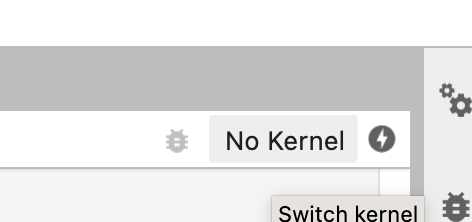
</div>


Click the text (in this case, "No Kernel") and look in the dropdown menu for the "mland_xr" environment. If it shows up already, great! Click it.

<div>

</div>



If it DOESN'T show up, shut down the JupyterHub session and re-launch it. To do that, navigate to  https://jupyterhub.hpc.ucar.edu/stable/hub/home  in your web browser. A list of sessions will be shown. Select "stop" next to your running session (probably "default"):

<div>

</div>



Wait a minute or so; you may have to refresh the page. Once the session is shut down, the "start" option will show next to it. Click "start" to re-launch the session. 


Repeat the first part of step 4 to find your environment. 

# Now that you have your environment loaded, we can import the packages we need for this JupyterLab session!

There are way more packages being imported below than we're actually going to use in this example notebook, but they are packages that are often useful so I'm leaving them here for now. 

In [1]:
%matplotlib inline
import sys

import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr
from scipy import interpolate
from numpy import ma
from scipy import stats
import scipy.io as sio
import pickle as pickle
from sklearn import linear_model
import numpy.ma as ma
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing

import scipy as sp
import pandas as pd

import time

from copy import copy 

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

# OS interaction
import os
import sys
import cftime

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

import matplotlib.colors as mcolors

import glob
import dask
import dask.bag as db

from scipy import interpolate

import statsmodels.stats.multitest as multitest

from matplotlib.gridspec import GridSpec
from cartopy.crs import EqualEarth, PlateCarree

## Now that packages are loaded, we can load some data. 

The RDA (Research Data Archive) section at NCAR keeps the ERA5 data up to date at this location: \
`/glade/collections/rda/data/ds633.0/`

You should read up on the details between "analysis" and "forecast" variables, and "instantaneous" vs "mean" vs "accumulated" ERA5 data here:
https://confluence.ecmwf.int/pages/viewpage.action?pageId=85402030

Latent heat flux (`slhf`) and sensible heat flux (`sshf`), convective precip `cp` and large-scale precip `lp` are 'forecast variables', which have both a forecast initiation time and a time-into-forecast. These are "accumulated" fields in the e5.oper.fc.sfc.accumu folder. 

For simplicity, here I'm just going to load 2m air temperature for every June from 2000 to 2009; these are in the e5.oper.an.sfc folder. 



In [2]:
era5_path = '/glade/campaign/collections/rda/data/ds633.0/'

In [3]:
# varlist = ['slhf','sshf','cp','lsp']
varlist = ['2t']

Other people may have *much more* efficient ways to load in ERA5 or CMIP data than this - but this works, so for now it is what I'll use:

In [4]:
ds_list = []

for var in varlist:
    print(var)
    
    files = glob.glob(era5_path + 'e5.oper.an.sfc/' + #'e5.oper.fc.sfc.accumu/' +
                      '200?06' + '/*'+var+'*.nc')
    files.sort
    
    # print(files)
    
    ds_temp = xr.open_mfdataset(files)
    
    ds_list.append(ds_temp)
    
ds = xr.merge(ds_list)
    

2t


In [5]:
os.path.isdir(era5_path + 'e5.oper.an.sfc/' + #'e5.oper.fc.sfc.accumu/' +
                      '200?06' + '/*'+var+'*.nc')

False

Now you should have a dataset `ds` that contains two variables, sshf and slhf, for every june from 2000 to 2009. Lets check:

In [6]:
print(list(ds.variables))

['VAR_2T', 'latitude', 'longitude', 'time', 'utc_date']


In [7]:
ds

<xarray.Dataset>
Dimensions:    (time: 7200, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2000-06-01 ... 2009-06-30T23:00:00
Data variables:
    VAR_2T     (time, latitude, longitude) float32 dask.array<chunksize=(720, 721, 1440), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(720,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.3
    CONVERSION_PLATFORM:  Linux r1i4n2 4.12.14-94.41-default #1 SMP Wed Oct 3...
    CONVERSION_DATE:      Fri Jul 26 21:34:41 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Fri Jul 26 21:34:57 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

xarray "lazy loads" data; it has found all the files we want to look at, but hasn't actually *loaded* the data from them, yet. You can explore the details of the dataset you've called up by using the interactive dropdown arrows. From this, we can see that the large-scale precip data alone that we've asked for, just for those 10 years, is almost 28 GB. That is a lot to load into memory to play with, and we really only want a very small region! So lets subset the data before we try and do anything with it:

In [6]:
ds_sw = ds.sel(latitude=slice(45,20),longitude=slice(238,264),drop=True)

In [9]:
ds_sw

<xarray.Dataset>
Dimensions:    (time: 7200, latitude: 101, longitude: 105)
Coordinates:
  * latitude   (latitude) float64 45.0 44.75 44.5 44.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 238.0 238.2 238.5 238.8 ... 263.5 263.8 264.0
  * time       (time) datetime64[ns] 2000-06-01 ... 2009-06-30T23:00:00
Data variables:
    VAR_2T     (time, latitude, longitude) float32 dask.array<chunksize=(720, 101, 105), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(720,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.3
    CONVERSION_PLATFORM:  Linux r1i4n2 4.12.14-94.41-default #1 SMP Wed Oct 3...
    CONVERSION_DATE:      Fri Jul 26 21:34:41 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Fri Jul 26 21:34:57 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

Okay, now a given variable is only ~250 MB for the 10 year period. We might actually have a chance of working with that! 

In general, xarray will load data when it needs it. In this case, we're doing to specifically ask xarray to load `ds_sw` (all of it, right now), so that it doesn't have to keep going back through all those files, opening them, and doing the spatial subsetting just to find the SW region, then loading the data from there. To do that, we do the following:

In [7]:
tic = time.perf_counter()

ds_sw.load()

toc = time.perf_counter()

print(f"Time to load: {toc - tic:0.4f} seconds")

Time to load: 67.6224 seconds


(the above step might take a while)


Now that the data is loaded, though, we can plot it without having to wait for xarray to load the data every time we ask for something.

NOTE that at this point, I haven't loaded a land mask, so we have data in a box that includes both land and ocean, extending from 20 S to 45 N and covering the western part of the USA and the northern part of Mexio. 


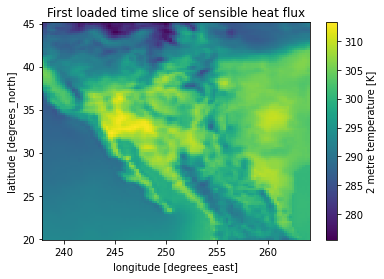

In [20]:
# ds_sw.SLHF.isel(forecast_hour=0,forecast_initial_time=0).plot()
ds_sw.VAR_2T.isel(time=0).plot()

# 
plt.title('First loaded time slice of sensible heat flux')
plt.show()
plt.close()


TypeError: '.dt' accessor only available for DataArray with datetime64 timedelta64 dtype or for arrays containing cftime datetime objects.

<xarray.DataArray 'year' (time: 7200)>
array([2000, 2000, 2000, ..., 2009, 2009, 2009])
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 ... 2009-06-30T23:00:00

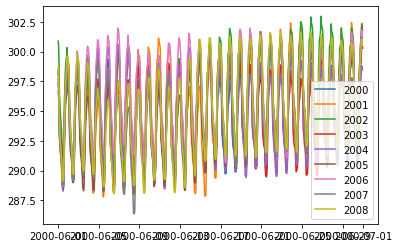

In [21]:
# get just the days of june to make the x-axis
june_days = ds_sw.where(ds['time'].dt.year.isin([2000]),drop=True).time

for year in range(2000,2009):
    
    ds_year = ds_sw.where(ds['time'].dt.year.isin([year]),drop=True)
    plt.plot(june_days,ds_year.VAR_2T.mean(['latitude','longitude']),label=year)

plt.legend()
plt.show()
plt.close()


That plot is super messy - rainbow spaghetti showing the hourly temperature for each year in a different colour. 

In [1]:
pwd

'/glade/work/zcleveland/ERA5_Example'

In [2]:
cd ../work

[Errno 2] No such file or directory: '../work'
/glade/work/zcleveland/ERA5_Example
